#  Mobile Games A/B Testing - Cookie Cats

Project summary: Cookie Cats, a popular mobile puzzle game, imposes a ‘gate’, where players are forced to wait a significant amount of time or make an in-app purchase to progress, as players continue to progress the game.  The A/B test was conducted to examine whether the ‘gate’ is better to be deployed in Level. 30 or Level. 40. After the data wrangling, exploration and application of Hypothesis testing, the business recommendation was made as:XXXXXXXXXXXXXXXXX

### 1. Problem Statement

[Cookie Cats](https://www.facebook.com/cookiecatsgame) is a hugely popular mobile puzzle game developed by [Tactile Entertainment](http://tactile.dk/). It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats.

As players progress through the levels of the game, they will **occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress**. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30. **In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.**

### 1.1 About the Dataset

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:
- 'userid':     special number given to each player
- 'version':     The players were split into two groups: one called the control group, where players had a gate at level 30 (gate_30), and the other called the test group, where players had a gate at level 40 (gate_40).
- 'sum_gamerounds':     They checked how many rounds of the game each player played in the first week after they installed the game. 
- 'retention_1':     They wanted to know if players came back to play the game again after 1 day.
- 'retention_7':     They also checked if players came back after 7 days. 

When a player got the game, they were randomly put into either the gate_30 or gate_40 group.

###  1.2 Designing the hypothesis
### Check the key metrics
- **Engagement metrics**
    - Retention rate

The key metric we ar egoing to take into account is the retention rate. The experiment records the retention after 1 day and 7 days respectively and the retention rate dor the both will be evaluated.

#### Form the hypothesis
This time, we are going to form the null hypothesis as:


$H0: p0 = p1$

which means that the control group is not significantly different from the treatment group.

While alternative hypothesis as:

$H1: p0 =! p1$

equals to the control group being significantly different from the treatment group.
Also, the alpha is defined as:

- Alpha(confidence interval): 
            $Alpha = 0.05$ 
            
This means the level of confidence interval as 95%.

#### Choose the variables
**Experiment groups:**
- **Control**: players encounter the gate in lv. 30
- **Treatment**: same in lv. 40

**Eligibility**
    - Players who signed up for the game within the assigned period


### Choose the sample size
The dataset here has 90,189 rows, which is large enough to perform a precise z-test

### A/B Testing Process

1. Understand the business problem & Data (Done in the section above)
2. Data Wrangling and cleaning
3. EDA - Sumary Statistics and Visualization
4. Hypothesis Testing 
    - Apply tests (z-tests)
5. Evaluate the results
6. Make inferences
7. Business Recommendations

## 2. Data Wrangling and cleaning

In [2]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/Users/asamitakeuchi/Game/cookie_cats.csv')

In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [7]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

No missing data

## 3. Exploratory Data Analysis - summey stats and Data Visualization

In [8]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


In [9]:
#summary stats of sum_gamerounds by versions
df.groupby('version').sum_gamerounds.agg(['count','min','max','mean','median','std'])

,count,min,max,mean,median,std
version,,,,,,
gate_30,44700,0,49854,52.456264,17.0,256.716423
gate_40,45489,0,2640,51.298776,16.0,103.294416


<Axes: xlabel='version', ylabel='sum_gamerounds'>

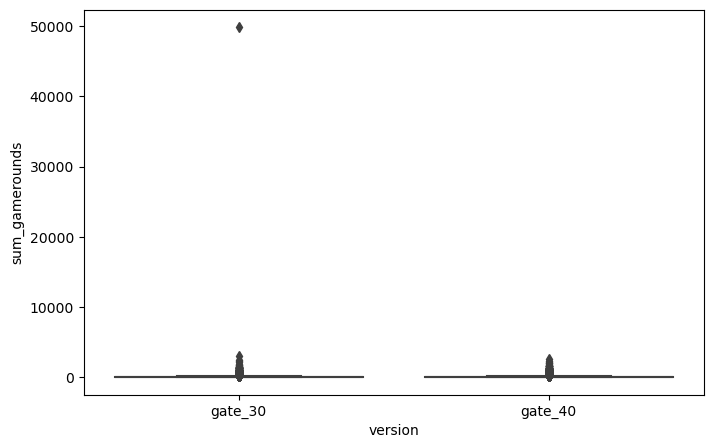

In [10]:
#check the outlier for sum_gamerounds
fig, ax = plt.subplots(figsize = (8,5))
sns.boxplot(x=df['version'], y=df['sum_gamerounds'])

There is an outlier in the gate_30 data (>50000)

In [11]:
#Check the number of people who played 0 rounds after installing
zero_df = df[df['sum_gamerounds'] == 0]
zero_df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,1937,1937,1937,1937
gate_40,2057,2057,2057,2057


3994 players nuver played the game after installing.

Text(0.5, 1.0, 'Distplot of total gamerounds by lv.30 vs lv.40 before removing the outlier')

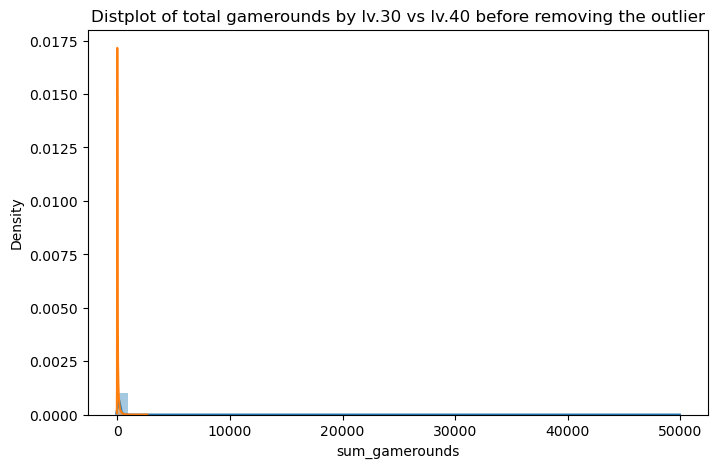

In [12]:
#Plot the distplot
sum_30 = df[df['version'] == 'gate_30']['sum_gamerounds']
sum_40 = df[df['version'] == 'gate_40']['sum_gamerounds']

fig, ax = plt.subplots(figsize = (8, 5))
ax1 = sns.distplot(sum_30)
ax2 = sns.distplot(sum_40)
ax.set_title(f'Distplot of total gamerounds by lv.30 vs lv.40 before removing the outlier')

In [13]:
#remove the outlier 
df_removed = df[df['sum_gamerounds'] < 40000]
df_removed.describe()

,userid,sum_gamerounds
count,9.018800e+04,90188.000000
mean,4.998397e+06,51.320253
std,2.883298e+06,102.682719
min,1.160000e+02,0.000000
25%,2.512211e+06,5.000000
50%,4.995804e+06,16.000000
75%,7.496461e+06,51.000000
max,9.999861e+06,2961.000000


The average total gamerounds played after removing outliers is 51.32 and median rounds is 16.
The distribution is highly long-tailed here.

The max round is 2961

In [14]:
#summary stats of sum_gamerounds with outlier removed by versions
df_removed.groupby('version').sum_gamerounds.agg(['count','min','max','mean','median','std'])

,count,min,max,mean,median,std
version,,,,,,
gate_30,44699,0,2961,51.342111,17.0,102.057598
gate_40,45489,0,2640,51.298776,16.0,103.294416


Text(0.5, 1.0, 'Total gamerounds by gate 30 vs gate 40')

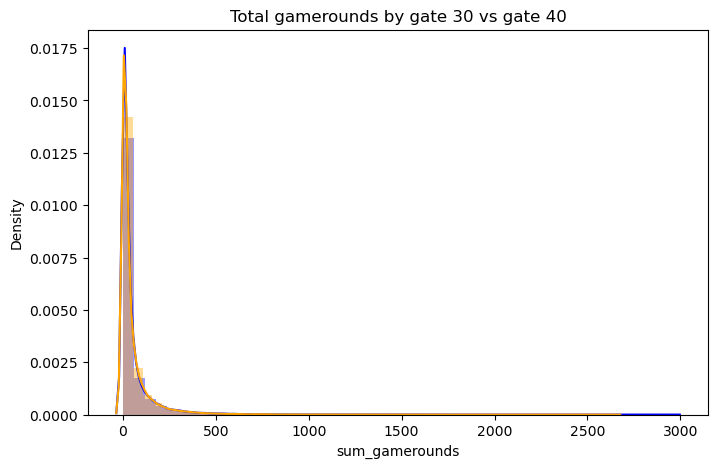

In [15]:
#plot distplot again
sumr_30 = df_removed[df_removed['version'] == 'gate_30']['sum_gamerounds']
sumr_40 = df_removed[df_removed['version'] == 'gate_40']['sum_gamerounds']

fig, ax = plt.subplots(figsize = (8, 5))
ax1 = sns.distplot(sumr_30, color='blue')
ax2 = sns.distplot(sumr_40, color='orange')
ax.set_title('Total gamerounds by gate 30 vs gate 40')

Text(0, 0.5, 'Frequency')

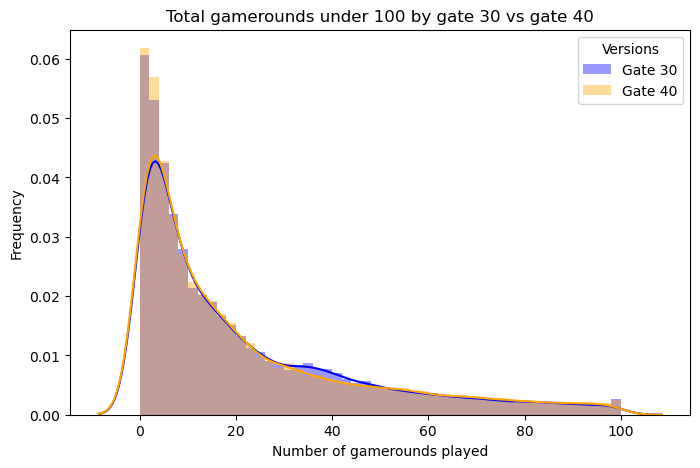

In [51]:
#plot distplot for the users within 100 rounds
# Filter the data for each version and where sum_gamerounds <= 100
sumr_30_500 = df_removed[(df_removed['version'] == 'gate_30') & (df_removed['sum_gamerounds'] <= 100)]['sum_gamerounds']
sumr_40_500 = df_removed[(df_removed['version'] == 'gate_40') & (df_removed['sum_gamerounds'] <= 100)]['sum_gamerounds']

fig, ax = plt.subplots(figsize = (8, 5))
ax1 = sns.distplot(sumr_30_500, color='blue', label='Gate 30')
ax2 = sns.distplot(sumr_40_500, color='orange', label='Gate 40')
ax.legend(title='Versions')
ax.set_title('Total gamerounds under 100 by gate 30 vs gate 40')
ax.set_xlabel('Number of gamerounds played')
ax.set_ylabel('Frequency')

In [17]:
#players retained in retention_1 and retention_7 by the version
#change the values to True = 1, False = 0
df_removed['retention_1'] = df_removed['retention_1'].astype(int)
df_removed['retention_7'] = df_removed['retention_7'].astype(int)
df_removed.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [18]:
#Check the retention rates by after 1 days and after 7 days
ret_1 = pd.crosstab(df_removed['version'], df_removed['retention_1'])
print(ret_1)

retention_1      0      1
version                  
gate_30      24665  20034
gate_40      25370  20119


In [19]:
ret_7 = pd.crosstab(df_removed['version'], df_removed['retention_7'])
print(ret_7)

retention_7      0     1
version                 
gate_30      36198  8501
gate_40      37210  8279


In [27]:
df_removed.groupby('version')[['retention_1','retention_7']].mean().round(4)

,retention_1,retention_7
version,,
gate_30,0.4482,0.1902
gate_40,0.4423,0.1820


It seems that the retention rates after 1 day is 44.8% for Gate 30 while 44.2% for Gate 40.
On the other hand, the retention rates after 7 days are 19% for Gate 30 and 18.2% for Gate 40.

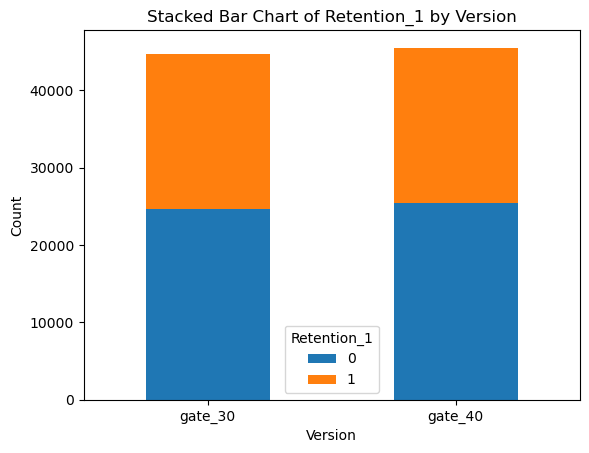

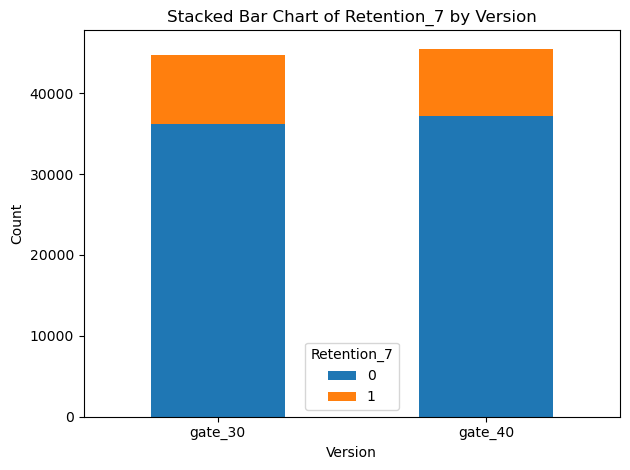

In [38]:
#Visualization of retention - stacked bar chart
# Group the data by 'version' and calculate the sum of 0s and 1s for each retention
# Group the data by 'version' and calculate the counts of 0s and 1s for each retention
grouped_retention_1 = df_removed.groupby('version')['retention_1'].value_counts().unstack(fill_value=0)
grouped_retention_7 = df_removed.groupby('version')['retention_7'].value_counts().unstack(fill_value=0)

# Plot stacked bar chart for retention_1
ax1 = grouped_retention_1.plot(kind='bar', stacked=True)
plt.xlabel('Version')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Retention_1 by Version')
plt.xticks(rotation=0)
plt.legend(title='Retention_1')

# Plot stacked bar chart for retention_7
ax2 = grouped_retention_7.plot(kind='bar', stacked=True)
plt.xlabel('Version')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Retention_7 by Version')
plt.xticks(rotation=0)
plt.legend(title='Retention_7')

plt.tight_layout()
plt.show()

###  Summary of findings so far
- There was no missing values but some outliers in the dataset.
- 3994 players never played the game after installing.
- As the game rounds progress, fewer players are retained in the game.
- The retention rates after 1 day are 44.8% (Gate 30)  vs 44.2% (Gate 40) while 7-day retention rates are 19% (Gate 30) vs 18.2% for (Gate 40). Putting the date at lv.30 has slightly higher retention in the both day(s).

## 4. Hypothesis Testing

###   z-test for 1 day retention

In [53]:
### Hypothesis Testing for retention after 1 day
control_1 = df_removed[df_removed['version']=='gate_30']['retention_1']
treatment_1 = df_removed[df_removed['version']=='gate_40']['retention_1']

In [54]:
n_con = control_1.count()
n_treat = treatment_1.count()
successes = [control_1.sum(), treatment_1.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Confidence interval 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'Confidence Interval 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.79
p-value: 0.074
Confidence interval 95% for control group: [0.444, 0.453]
Confidence Interval 95% for treatment group: [0.438, 0.447]


#### Insights:
The z statistic measures how many standard deviations the sample mean is away from the hypothesized population mean under the null hypothesis. z statistic here is positive and indicates that score is higher than the mean.
p-value is above the predifined significance level of 0.005 but is pretty close to it. 
The null is not strictly rejected but it would be better to put the gate in the lv 30.

###  z-test for 7 day retention

In [57]:
### Hypothesis Testing for retention after 1 day
control_1 = df_removed[df_removed['version']=='gate_30']['retention_7']
treatment_1 = df_removed[df_removed['version']=='gate_40']['retention_7']

In [58]:
n_con = control_1.count()
n_treat = treatment_1.count()
successes = [control_1.sum(), treatment_1.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Confidence interval 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'Confidence Interval 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 3.16
p-value: 0.002
Confidence interval 95% for control group: [0.187, 0.194]
Confidence Interval 95% for treatment group: [0.178, 0.186]


#### Insights:
The p-value is way below the 0.05 significance level and null is clearly rejected. Also, z statistics is larger than 1 day retention, indicating larger standard deviation away from the mean.
The gate should stay in the Lv 30 to retain the users for 7 days.

# Conclusions

The business question was: does moving the first gate in Cookie Cats from level 30 to level 40 affect player retention and number of rounds. This time, we set the retention rate as the primary metric to assess the problem.

By performing z-test, the null hypothesis, at which defined as the both group do not have significant difference at retention rate, was rejected, particularly for 7-day retention rate. While 1-day retention rate does not have a significant difference between the both level, the significance level was not so far from the thueshold of 0.05 and not strongly denied. The 7-day retention was clearly higher for lv 30 group with retention rate between 18.7 - 19.4% for the control group with 95% confidence level.

The suggestion that can be made from this result is: the gate should stay in Lv. 30 to retain the customer for both 1 day and 7 days, especially for the 7-day retention rates.

Additional insights found form examining the data was:
- There was no missing values but some outliers in the dataset.
- 3994 players never played the game after installing.
- As the game rounds progress, fewer players are retained in the game.